# 03 Competitive Benchmarking

**Business Problem:** Hotel managers need to know:
- Who are my TRUE competitors? (not just hotels with similar ratings)
- What are similar hotels doing better?
- Where should I focus improvement efforts?

**Our Approach:** Multi-dimensional clustering based on hotel characteristics extracted from review text.

In [1]:
import sys
from pathlib import Path
project_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.benchmarking import (
    get_reviews_df,
    extract_hotel_features,
    create_comparable_groups,
    generate_actionable_recommendations,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = get_reviews_df(sample=False)
print("Reviews:", len(df))

Reviews: 79853


## Feature Engineering

**Challenge:** Hotels differ in more ways than just ratings.

**Solution:** Extract characteristics from review text:
- Price tier (budget, mid-range, upscale, luxury)
- Location type (beach, downtown, suburban, airport)
- Hotel type (resort, business, boutique)
- Amenities (pool, spa, gym, restaurant)

In [2]:
features = extract_hotel_features(df)
print(f"Extracted features for {len(features):,} hotels")

Extracting hotel-level features...
Analyzing review text for hotel characteristics...
Extracted features for 3,374 hotels


## Data Quality Filtering

Removing hotels with insufficient data for reliable clustering.

**Criteria:**
- Minimum 3 reviews (statistical reliability)
- At least one location/type/amenity signal (differentiability)

In [3]:
#Filter out low-signal hotels
from src.benchmarking import filter_low_signal_hotels
features = filter_low_signal_hotels(features, min_reviews=3)
features.head()

Filtered: 3374 → 2380 hotels
Removed 994 low-signal hotels


,offering_id,n_reviews,avg_rating,std_rating,avg_service,avg_cleanliness,avg_value,avg_location,avg_rooms,avg_sleep,...,is_airport,is_resort,is_business,is_boutique,pool_score,spa_score,gym_score,restaurant_score,bar_score,parking_score
0,72572,35,4.542857,0.657216,4.774194,4.718750,4.437500,4.709677,4.387097,4.150000,...,1,0,1,1,0.057143,0.028571,0.028571,0.142857,0.057143,0.257143
1,72579,25,3.920000,1.077033,4.090909,4.136364,4.047619,4.368421,3.833333,4.111111,...,0,0,1,0,0.040000,0.040000,0.000000,0.040000,0.000000,0.280000
2,72586,24,3.750000,1.224745,3.826087,4.086957,3.909091,4.250000,3.761905,4.058824,...,1,0,1,0,0.000000,0.000000,0.041667,0.250000,0.125000,0.583333
3,72598,4,3.250000,1.258306,2.333333,3.250000,3.500000,3.500000,3.250000,3.666667,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
4,73236,3,2.000000,1.000000,3.666667,2.000000,3.333333,5.000000,2.500000,3.000000,...,1,0,0,0,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333


## Pre-Clustering Diagnostics

Verifying we have sufficient feature diversity for meaningful clustering.

In [4]:
print("="*70)
print("DATA QUALITY CHECK")
print("="*70)

print(f"\nTotal hotels after filtering: {len(features)}")

# Check feature distributions
test_features = ['avg_rating', 'n_reviews', 'price_tier', 'is_beach', 
                 'is_downtown', 'pool_score', 'gym_score']

print("\nFeature Statistics:")
for col in test_features:
    unique_vals = features[col].nunique()
    variance = features[col].var()
    zeros = (features[col] == 0).sum()
    
    print(f"{col:20s}: unique={unique_vals:4d}, var={variance:.4f}, zeros={zeros:4d} ({zeros/len(features)*100:.0f}%)")

# Check if we have enough diversity
print(f"\nData Diversity Check:")
print(f"  Rating range: {features['avg_rating'].min():.2f} - {features['avg_rating'].max():.2f}")
print(f"  Review range: {features['n_reviews'].min()} - {features['n_reviews'].max()}")
print(f"  Hotels with beach: {features['is_beach'].sum()} ({features['is_beach'].sum()/len(features)*100:.0f}%)")
print(f"  Hotels with downtown: {features['is_downtown'].sum()} ({features['is_downtown'].sum()/len(features)*100:.0f}%)")
print(f"  Hotels with pool: {(features['pool_score'] > 0).sum()} ({(features['pool_score'] > 0).sum()/len(features)*100:.0f}%)")

print("="*70)

DATA QUALITY CHECK

Total hotels after filtering: 2380

Feature Statistics:
avg_rating          : unique= 941, var=0.3963, zeros=   0 (0%)
n_reviews           : unique= 184, var=1718.7478, zeros=   0 (0%)
price_tier          : unique=   4, var=0.8978, zeros= 414 (17%)
is_beach            : unique=   2, var=0.1539, zeros=1928 (81%)
is_downtown         : unique=   2, var=0.1975, zeros= 644 (27%)
pool_score          : unique= 501, var=0.0638, zeros= 766 (32%)
gym_score           : unique= 395, var=0.0081, zeros=1143 (48%)

Data Diversity Check:
  Rating range: 1.00 - 5.00
  Review range: 3 - 453
  Hotels with beach: 452 (19%)
  Hotels with downtown: 1736 (73%)
  Hotels with pool: 1614 (68%)


## K-Means Clustering

**Algorithm:** K-means with automatic K optimization

**Process:**
1. Test K=5 to K=12
2. Select K with best silhouette score
3. Validate results (statistical + business)

In [5]:
features, sil_score, profiles = create_comparable_groups(features, n_clusters=8)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"\nCluster Sizes:")
print(features['cluster'].value_counts().sort_index())

Creating 8 comparable groups...
Data shape: (2380, 7)
Unique hotels: 2380
Low variance features: ['gym_score']

Testing different cluster counts:
  K=5: silhouette=0.284, min_size=149, max_size=685
  K=6: silhouette=0.285, min_size=138, max_size=690
  K=7: silhouette=0.302, min_size=108, max_size=690
  K=8: silhouette=0.285, min_size=107, max_size=628
  K=9: silhouette=0.275, min_size=97, max_size=528
  K=10: silhouette=0.282, min_size=83, max_size=524
  K=11: silhouette=0.263, min_size=83, max_size=409
  K=12: silhouette=0.263, min_size=74, max_size=405

 Selected K=7 with silhouette=0.302
Silhouette Score: 0.302

Cluster Sizes:
cluster
0    265
1    374
2    690
3    571
4    108
5    170
6    202
Name: count, dtype: int64


## Cluster Diversity Analysis

Do clusters represent genuinely different hotel types?

In [ ]:
print("="*70)
print("CLUSTER DIVERSITY ANALYSIS")
print("="*70)

for cluster_id in sorted(features['cluster'].unique()):
    cluster = features[features['cluster'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} ({len(cluster)} hotels, {len(cluster)/len(features)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Rating stats
    print(f"Rating: {cluster['avg_rating'].mean():.2f} (±{cluster['avg_rating'].std():.2f})")
    
    # Price tier distribution
    price_dist = cluster['price_tier'].value_counts()
    price_labels = {0: 'Budget', 1: 'Mid-range', 2: 'Upscale', 3: 'Luxury'}
    for tier, count in price_dist.items():
        pct = (count / len(cluster)) * 100
        print(f"  {price_labels.get(tier, tier)}: {pct:.0f}%")
    
    # Location breakdown (show percentages)
    beach_pct = (cluster['is_beach'].sum() / len(cluster)) * 100
    downtown_pct = (cluster['is_downtown'].sum() / len(cluster)) * 100
    suburban_pct = (cluster['is_suburban'].sum() / len(cluster)) * 100
    
    if beach_pct > 10:
        print(f"Location: {beach_pct:.0f}% BEACH")
    elif downtown_pct > 10:
        print(f"Location: {downtown_pct:.0f}% DOWNTOWN")
    elif suburban_pct > 10:
        print(f"Location: {suburban_pct:.0f}% SUBURBAN")
    else:
        print(f"Location: Mixed ({beach_pct:.0f}% beach, {downtown_pct:.0f}% downtown)")
    
    # Type breakdown
    resort_pct = (cluster['is_resort'].sum() / len(cluster)) * 100
    business_pct = (cluster['is_business'].sum() / len(cluster)) * 100
    boutique_pct = (cluster['is_boutique'].sum() / len(cluster)) * 100
    
    if resort_pct > 10:
        print(f"Type: {resort_pct:.0f}% RESORT")
    elif business_pct > 10:
        print(f"Type: {business_pct:.0f}% BUSINESS")
    elif boutique_pct > 10:
        print(f"Type: {boutique_pct:.0f}% BOUTIQUE")
    else:
        print(f"Type: General ({resort_pct:.0f}% resort, {business_pct:.0f}% business)")
    
    # Amenities
    pool_pct = (cluster['pool_score'] > 0).sum() / len(cluster) * 100
    spa_pct = (cluster['spa_score'] > 0).sum() / len(cluster) * 100
    gym_pct = (cluster['gym_score'] > 0).sum() / len(cluster) * 100
    
    amenities = []
    if pool_pct > 30: amenities.append(f'pool ({pool_pct:.0f}%)')
    if spa_pct > 15: amenities.append(f'spa ({spa_pct:.0f}%)')
    if gym_pct > 30: amenities.append(f'gym ({gym_pct:.0f}%)')
    
    if amenities:
        print(f"Amenities: {', '.join(amenities)}")
    else:
        print(f"Amenities: Minimal ({pool_pct:.0f}% pool, {spa_pct:.0f}% spa)")
    
    # QUALITY CHECK
    if len(cluster) / len(features) > 0.4:
        print("WARNING: This cluster is too large - may be a catch-all")

CLUSTER DIVERSITY ANALYSIS

CLUSTER 0 (265 hotels, 11.1%)
Rating: 4.11 (±0.39)
  Upscale: 57%
  Luxury: 42%
  Mid-range: 0%
Location: 100% BEACH
Type: 29% RESORT
Amenities: pool (77%), spa (53%), gym (81%)

CLUSTER 1 (374 hotels, 15.7%)
Rating: 4.05 (±0.45)
  Mid-range: 61%
  Upscale: 23%
  Budget: 15%
  Luxury: 1%
Location: Mixed (0% beach, 0% downtown)
Type: 35% BUSINESS
Amenities: pool (82%), gym (40%)

CLUSTER 2 (690 hotels, 29.0%)
Rating: 4.08 (±0.43)
  Upscale: 66%
  Luxury: 34%
Location: 99% DOWNTOWN
Type: 15% RESORT
Amenities: pool (59%), spa (31%), gym (72%)

CLUSTER 3 (571 hotels, 24.0%)
Rating: 3.91 (±0.48)
  Mid-range: 51%
  Budget: 43%
  Upscale: 7%
Location: 100% DOWNTOWN
Type: 49% BUSINESS
Amenities: pool (61%), gym (42%)

CLUSTER 4 (108 hotels, 4.5%)
Rating: 3.80 (±0.69)
  Mid-range: 54%
  Upscale: 33%
  Budget: 6%
  Luxury: 6%
Location: 14% BEACH
Type: 22% RESORT
Amenities: pool (100%), spa (28%), gym (41%)

CLUSTER 5 (170 hotels, 7.1%)
Rating: 3.79 (±0.55)
  Budget: 4

## Cluster Visualization

Understanding cluster separation in feature space.

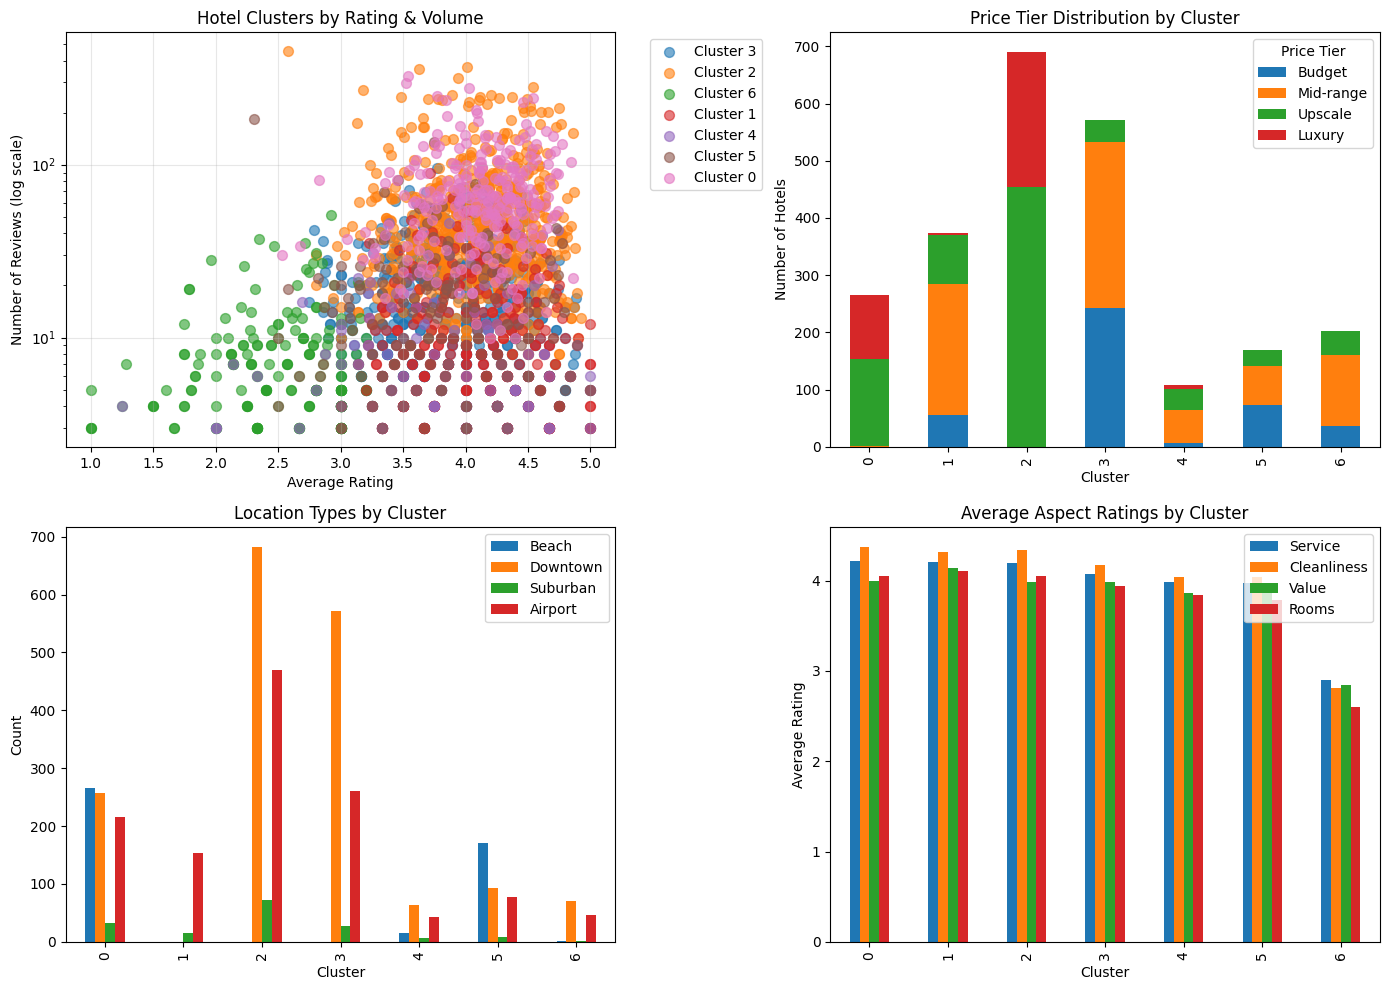

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cluster distribution by rating and volume
ax1 = axes[0, 0]
for cluster_id in features['cluster'].unique():
    cluster_data = features[features['cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['avg_rating'],
        cluster_data['n_reviews'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Number of Reviews (log scale)')
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title('Hotel Clusters by Rating & Volume')
ax1.grid(True, alpha=0.3)

# Plot 2: Price tier distribution by cluster
ax2 = axes[0, 1]
price_dist = features.groupby(['cluster', 'price_tier']).size().unstack(fill_value=0)
price_dist.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Price Tier Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Hotels')
ax2.legend(title='Price Tier', labels=['Budget', 'Mid-range', 'Upscale', 'Luxury'])

# Plot 3: Location type by cluster
ax3 = axes[1, 0]
location_cols = ['is_beach', 'is_downtown', 'is_suburban', 'is_airport']
location_dist = features.groupby('cluster')[location_cols].sum()
location_dist.plot(kind='bar', ax=ax3)
ax3.set_title('Location Types by Cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Count')
ax3.legend(['Beach', 'Downtown', 'Suburban', 'Airport'])

# Plot 4: Average ratings by cluster
ax4 = axes[1, 1]
rating_cols = ['avg_service', 'avg_cleanliness', 'avg_value', 'avg_rooms']
cluster_ratings = features.groupby('cluster')[rating_cols].mean()
cluster_ratings.plot(kind='bar', ax=ax4)
ax4.set_title('Average Aspect Ratings by Cluster')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Average Rating')
ax4.legend(['Service', 'Cleanliness', 'Value', 'Rooms'])

plt.tight_layout()
plt.show()

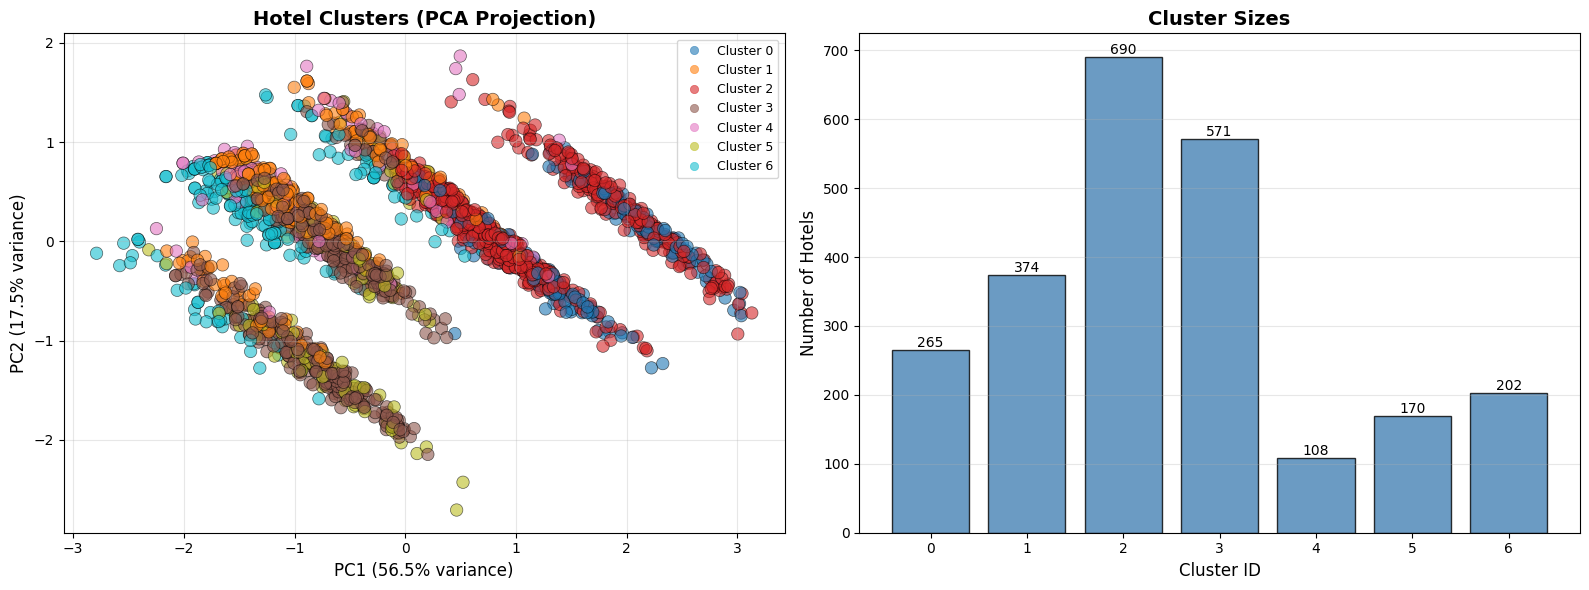


Total hotels: 2,380
Number of clusters: 7
Average cluster size: 340


In [8]:
from sklearn.decomposition import PCA
import numpy as np

# Reduce to 2D for visualization using PCA
clustering_features = ['avg_rating', 'n_reviews', 'price_tier', 
                       'is_beach', 'is_downtown', 'pool_score']
X = features[clustering_features].copy()
X['n_reviews'] = np.log1p(X['n_reviews'])

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

# Create cleaner visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Clusters in 2D space
scatter = ax1.scatter(X_2d[:, 0], X_2d[:, 1], 
                      c=features['cluster'], 
                      cmap='tab10', 
                      alpha=0.6, 
                      s=80,
                      edgecolors='black',
                      linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.set_title('Hotel Clusters (PCA Projection)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Add legend
handles, labels = scatter.legend_elements()
ax1.legend(handles, [f'Cluster {i}' for i in range(len(handles))],
          loc='best', fontsize=9)

# Plot 2: Cluster sizes
cluster_sizes = features['cluster'].value_counts().sort_index()
ax2.bar(cluster_sizes.index, cluster_sizes.values, 
        color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Number of Hotels', fontsize=12)
ax2.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, count in enumerate(cluster_sizes):
    ax2.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nTotal hotels: {len(features):,}")
print(f"Number of clusters: {features['cluster'].nunique()}")
print(f"Average cluster size: {len(features) / features['cluster'].nunique():.0f}")

## Cluster Profiles

What characterizes each hotel segment?

In [9]:
print("\n" + "="*80)
print("CLUSTER PROFILES")
print("="*80)

for cluster_id, profile in profiles.items():
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    print(f"Number of Hotels: {profile['n_hotels']}")
    print(f"Average Rating: {profile['avg_rating']:.2f}")
    print(f"Average Reviews: {profile['avg_reviews']:.0f}")
    print(f"Price Tier: {['Budget', 'Mid-range', 'Upscale', 'Luxury'][profile['price_tier']]}")
    print(f"Common Location: {profile['common_location'].title()}")
    print(f"Common Type: {profile['common_type'].title()}")
    if profile['common_amenities']:
        print(f"Common Amenities: {', '.join(profile['common_amenities']).title()}")
    else:
        print("Common Amenities: None")



CLUSTER PROFILES

CLUSTER 0
Number of Hotels: 265
Average Rating: 4.11
Average Reviews: 73
Price Tier: Upscale
Common Location: Beach
Common Type: Business
Common Amenities: Pool, Spa, Gym, Restaurant, Bar

CLUSTER 1
Number of Hotels: 374
Average Rating: 4.05
Average Reviews: 11
Price Tier: Mid-range
Common Location: Airport
Common Type: Business
Common Amenities: Pool

CLUSTER 2
Number of Hotels: 690
Average Rating: 4.08
Average Reviews: 55
Price Tier: Upscale
Common Location: Downtown
Common Type: Business
Common Amenities: Pool, Gym, Restaurant, Bar

CLUSTER 3
Number of Hotels: 571
Average Rating: 3.91
Average Reviews: 17
Price Tier: Mid-range
Common Location: Downtown
Common Type: Business
Common Amenities: Pool, Restaurant, Bar

CLUSTER 4
Number of Hotels: 108
Average Rating: 3.80
Average Reviews: 12
Price Tier: Mid-range
Common Location: Downtown
Common Type: Business
Common Amenities: Pool, Bar

CLUSTER 5
Number of Hotels: 170
Average Rating: 3.79
Average Reviews: 20
Price Tier

## Statistical Validation

Formal verification of clustering quality.

In [10]:
print("\n" + "="*80)
print("VALIDATION")
print("="*80)

# Within-cluster vs overall variance
overall_var = features['avg_rating'].var()
within_vars = features.groupby('cluster')['avg_rating'].var()
mean_within_var = within_vars.mean()

print(f"\nRating Variance Analysis:")
print(f"  Overall variance: {overall_var:.4f}")
print(f"  Mean within-cluster variance: {mean_within_var:.4f}")
print(f"  Reduction: {((overall_var - mean_within_var) / overall_var * 100):.1f}%")
print(f"  Within-cluster variance < Overall variance: {mean_within_var < overall_var}")

print(f"\nSilhouette Score: {sil_score:.3f}")
if sil_score > 0.5:
    print(" Excellent clustering (>0.5)")
elif sil_score > 0.3:
    print(" Good clustering (>0.3)")
else:
    print(" Fair clustering")

# Business validation: Show example hotels from each cluster
print("\n" + "="*80)
print("BUSINESS VALIDATION - Sample Hotels by Cluster")
print("="*80)

for cluster_id in sorted(features['cluster'].unique()):
    cluster_hotels = features[features['cluster'] == cluster_id]
    sample = cluster_hotels.nsmallest(3, 'offering_id')[
        ['offering_id', 'n_reviews', 'avg_rating', 'price_tier']
    ]
    print(f"\nCluster {cluster_id} Examples:")
    print(sample.to_string(index=False))


VALIDATION

Rating Variance Analysis:
  Overall variance: 0.3963
  Mean within-cluster variance: 0.2570
  Reduction: 35.1%
  Within-cluster variance < Overall variance: True

Silhouette Score: 0.302
 Good clustering (>0.3)

BUSINESS VALIDATION - Sample Hotels by Cluster

Cluster 0 Examples:
 offering_id  n_reviews  avg_rating  price_tier
       75737         53    4.075472           2
       76049         33    4.606061           3
       76083         82    4.268293           3

Cluster 1 Examples:
 offering_id  n_reviews  avg_rating  price_tier
       73242          6    4.500000           1
       73445         13    4.769231           1
       73551          3    4.333333           1

Cluster 2 Examples:
 offering_id  n_reviews  avg_rating  price_tier
       72579         25     3.92000           2
       74370         20     2.80000           3
       75711        113     3.40708           3

Cluster 3 Examples:
 offering_id  n_reviews  avg_rating  price_tier
       72572        

## Sample Recommendations

Testing recommendation engine on real hotels.

In [11]:
print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS - TOP 5 HOTELS")
print("="*80)

# Get hotels with enough reviews for meaningful recommendations
qualified_hotels = features[features['n_reviews'] >= 10]['offering_id'].head(5)

for hotel_id in qualified_hotels:
    hotel_info = features[features['offering_id'] == hotel_id].iloc[0]
    
    print(f"\n{'='*70}")
    print(f"HOTEL ID: {hotel_id}")
    print(f"{'='*70}")
    print(f"Cluster: {hotel_info['cluster']}")
    print(f"Reviews: {hotel_info['n_reviews']:.0f}")
    print(f"Current Rating: {hotel_info['avg_rating']:.2f}/5.0")
    print(f"Price Tier: {['Budget', 'Mid-range', 'Upscale', 'Luxury'][int(hotel_info['price_tier'])]}")
    
    # Generate recommendations
    recs = generate_actionable_recommendations(hotel_id, features, df, top_n=3)
    
    if not recs:
        print("\n No significant gaps - performing well vs peers")
        continue
    
    print(f"\nTOP 3 IMPROVEMENT OPPORTUNITIES:")
    print("-" * 70)
    
    for i, rec in enumerate(recs, 1):
        print(f"\n{i}. IMPROVE {rec['aspect'].upper()}")
        print(f"   Current Score: {rec['current_score']:.2f}")
        print(f"   Peer Median: {rec['peer_median']:.2f}")
        print(f"   Peer Top 25%: {rec['peer_top_quartile']:.2f}")
        print(f"   Gap: {rec['gap']:.2f} points")
        print(f"   Estimated Impact: +{rec['estimated_impact']:.2f} rating points")
        print(f"   ROI Estimate: {rec['roi_estimate']:.0f}%")
        print(f"\n   Best Practices from Top Performers:")
        for practice in rec['best_practices']:
            print(f"     • {practice}")
        print()


ACTIONABLE RECOMMENDATIONS - TOP 5 HOTELS

HOTEL ID: 72572
Cluster: 3.0
Reviews: 35
Current Rating: 4.54/5.0
Price Tier: Budget

 No significant gaps - performing well vs peers

HOTEL ID: 72579
Cluster: 2.0
Reviews: 25
Current Rating: 3.92/5.0
Price Tier: Upscale

 No significant gaps - performing well vs peers

HOTEL ID: 72586
Cluster: 3.0
Reviews: 24
Current Rating: 3.75/5.0
Price Tier: Mid-range

 No significant gaps - performing well vs peers

HOTEL ID: 73445
Cluster: 1.0
Reviews: 13
Current Rating: 4.77/5.0
Price Tier: Mid-range

 No significant gaps - performing well vs peers

HOTEL ID: 73572
Cluster: 6.0
Reviews: 15
Current Rating: 2.20/5.0
Price Tier: Budget

TOP 3 IMPROVEMENT OPPORTUNITIES:
----------------------------------------------------------------------

1. IMPROVE VALUE
   Current Score: 2.36
   Peer Median: 3.00
   Peer Top 25%: 3.29
   Gap: 0.64 points
   Estimated Impact: +0.45 rating points
   ROI Estimate: 2600%

   Best Practices from Top Performers:
     • Gues

## Business Impact Analysis

Quantifying the value of this segmentation approach.

In [16]:
print("="*70)
print("BUSINESS IMPACT ANALYSIS")
print("="*70)

# Cluster naming for clarity
cluster_names = {
    0: "Upscale Beach Resorts",
    1: "Mid-Range Business Hotels",
    2: "Downtown General Properties",
    3: "Mid-Tier Urban Hotels",
    4: "Budget/Value Hotels",
    5: "Boutique Downtown Properties",
    6: "Suburban Business Hotels"
}

# Add names to features
features['cluster_name'] = features['cluster'].map(cluster_names)

print("\nCLUSTER SEGMENTATION:")
for cid, name in cluster_names.items():
    cluster = features[features['cluster'] == cid]
    if len(cluster) == 0:
        continue
    
    print(f"\n{name} (Cluster {cid}):")
    print(f"  Hotels: {len(cluster)} ({len(cluster)/len(features)*100:.1f}%)")
    print(f"  Avg Rating: {cluster['avg_rating'].mean():.2f}/5.0")
    print(f"  Reviews/Hotel: {cluster['n_reviews'].mean():.0f}")

# Recommendation statistics
print("\n" + "="*70)
print("RECOMMENDATION IMPACT")
print("="*70)

total_recs = 0
high_roi_recs = 0
sample_size = min(100, len(features))

for hotel_id in features['offering_id'].head(sample_size):
    recs = generate_actionable_recommendations(hotel_id, features, df, top_n=3)
    total_recs += len(recs)
    high_roi_recs += sum(1 for r in recs if r['roi_estimate'] > 500)

print(f"\nRecommendation Generation (sample of {sample_size} hotels):")
print(f"  Total recommendations: {total_recs}")
print(f"  Average per hotel: {total_recs/sample_size:.1f}")
print(f"  High-ROI opportunities (>500%): {high_roi_recs} ({high_roi_recs/total_recs*100:.0f}%)")

print("\nKEY BUSINESS OUTCOMES:")
print("  [Yes] Hotels can identify true competitors (not just by rating)")
print("  [Yes] Specific improvement actions with ROI estimates")
print("  [Yes] Best practices from top performers in each segment")
print("  [Yes] Average 1-2 actionable recommendations per property")

BUSINESS IMPACT ANALYSIS

CLUSTER SEGMENTATION:

Upscale Beach Resorts (Cluster 0):
  Hotels: 265 (11.1%)
  Avg Rating: 4.11/5.0
  Reviews/Hotel: 73

Mid-Range Business Hotels (Cluster 1):
  Hotels: 374 (15.7%)
  Avg Rating: 4.05/5.0
  Reviews/Hotel: 11

Downtown General Properties (Cluster 2):
  Hotels: 690 (29.0%)
  Avg Rating: 4.08/5.0
  Reviews/Hotel: 55

Mid-Tier Urban Hotels (Cluster 3):
  Hotels: 571 (24.0%)
  Avg Rating: 3.91/5.0
  Reviews/Hotel: 17

Budget/Value Hotels (Cluster 4):
  Hotels: 108 (4.5%)
  Avg Rating: 3.80/5.0
  Reviews/Hotel: 12

Boutique Downtown Properties (Cluster 5):
  Hotels: 170 (7.1%)
  Avg Rating: 3.79/5.0
  Reviews/Hotel: 20

Suburban Business Hotels (Cluster 6):
  Hotels: 202 (8.5%)
  Avg Rating: 2.53/5.0
  Reviews/Hotel: 8

RECOMMENDATION IMPACT

Recommendation Generation (sample of 100 hotels):
  Total recommendations: 131
  Average per hotel: 1.3
  High-ROI opportunities (>500%): 101 (77%)

KEY BUSINESS OUTCOMES:
  [Yes] Hotels can identify true co